In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-03-06 16:20:29.449164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 16:20:29.459467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741274429.471741   46654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741274429.475215   46654 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 16:20:29.487936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PreprocessingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        min_val = tf.reduce_min(inputs, axis=0)
        max_val = tf.reduce_max(inputs, axis=0)
        normalized_inputs = tf.where(
            max_val - min_val != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            tf.zeros_like(inputs),
        )
        return normalized_inputs

In [3]:
class Autoencoder:
    """Autoencoder that reconstruct METSig distributions and flag anomalies"""

    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        input_layer = tf.keras.Input(shape=input_shape)
        prep_layer = PreprocessingLayer()(input_layer)
        encoded = tf.keras.layers.Dense(18, activation="relu", activity_regularizer=tf.keras.regularizers.l2(l2_lambda))(prep_layer)
        encoded = tf.keras.layers.Dense(8, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(18, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(input_shape[0], activation="sigmoid")(decoded)
        self.model = tf.keras.models.Model(input_layer, decoded)

        # Since `avg_mse` shares the same layers (prep_layer and decoded) as the `self.model`
        # this `self.stripped_model` doesn't need to be trained
        avg_mse = tf.keras.losses.MSE(prep_layer, decoded)  # Compute the mean squared error for each row in the inputs
        self.stripped_model = tf.keras.models.Model(input_layer, avg_mse)

    def compile(self):
        self.model.compile(optimizer="adam", loss=["mse"], metrics=["mse"])

    def summary(self):
        self.model.summary()

    def predict(self, inputs: np.ndarray):
        return self.model.predict(inputs)

    def fit(self, inputs: np.ndarray, batch_size: int, epochs: int):
        targets = PreprocessingLayer()(inputs)
        history: tf.keras.callbacks.History = self.model.fit(
            inputs, targets, batch_size=batch_size, epochs=epochs
        )
        return history

In [4]:
train_data = np.load("../data/data_386642.npy")
train_label = np.load("../data/label_386642.npy")

# We want to feed the Autoencoder with GOOD data, so we filter the data by the label == 1
train_data = train_data[train_label == 1]
train_data

array([[1940., 1987.,  670., ...,    0.,    0.,    0.],
       [1869., 1872.,  714., ...,    0.,    0.,    0.],
       [1819., 1924.,  672., ...,    0.,    0.,    0.],
       ...,
       [1171.,  989.,  293., ...,    0.,    0.,    0.],
       [1225.,  960.,  289., ...,    0.,    0.,    0.],
       [1190.,  994.,  257., ...,    0.,    0.,    0.]])

In [5]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
ae.compile()
ae.summary()

2025-03-06 16:20:30.969663: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing_layer             │ (None, 51)             │             0 │
│ (PreprocessingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 51)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = ae.fit(train_data, 128, 200)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2065 - mse: 0.1953  
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1920 - mse: 0.1829 
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1793 - mse: 0.1715 
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1665 - mse: 0.1604 
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1547 - mse: 0.1496 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1438 - mse: 0.1396 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1335 - mse: 0.1300 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1234 - mse: 0.1205 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1139 - mse: 0.1115 
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1054 - mse: 0.1036 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0974 - mse: 0.0957 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0901 - mse: 0.0887 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

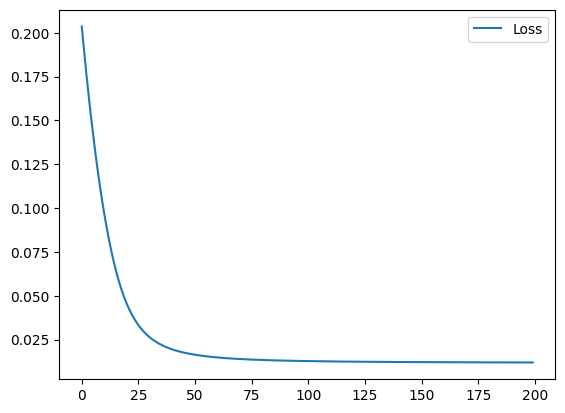

In [7]:
plt.plot(history.history['loss'], label="Loss")
plt.legend()
plt.show()

In [8]:
ae.model.predict(train_data)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[0.7744969 , 0.70154715, 0.55967736, ..., 0.01821313, 0.02240672,
        0.01793109],
       [0.7744969 , 0.70154715, 0.55967736, ..., 0.01821313, 0.02240672,
        0.01793109],
       [0.77446234, 0.7015953 , 0.5596642 , ..., 0.01821915, 0.02242015,
        0.01793751],
       ...,
       [0.77497095, 0.70223504, 0.5600356 , ..., 0.01802483, 0.02220454,
        0.01774113],
       [0.7744969 , 0.70154715, 0.55967736, ..., 0.01821313, 0.02240672,
        0.01793109],
       [0.7748136 , 0.7014252 , 0.5596877 , ..., 0.0181079 , 0.02226654,
        0.0178339 ]], dtype=float32)

In [9]:
ae.stripped_model.summary()
ae.stripped_model.predict(train_data)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_layer │ (None, 51)        │          0 │ input_layer[0][0] │
│ (PreprocessingLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 18)        │        936 │ preprocessing_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18)        │        162 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 51)        │        969 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convert_to_tensor_1 │ (None, 51)        │          0 │ preprocessing_la… │
│ (ConvertToTensor)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convert_to_tensor   │ (None, 51)        │          0 │ dense_3[0][0]     │
│ (ConvertToTensor)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 51)        │          0 │ convert_to_tenso… │
│                     │                   │            │ convert_to_tenso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ square (Square)     │ (None, 51)        │          0 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Mean)         │ (None)            │          0 │ square[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([0.02622933, 0.03181145, 0.04320111, 0.05795019, 0.0103389 ,
       0.05049328, 0.00876535, 0.00988122, 0.02610688, 0.06245252,
       0.03201437, 0.01195818, 0.04108442, 0.01075046, 0.03926809,
       0.03666726, 0.05400687, 0.05772702, 0.00734805, 0.03454347,
       0.02107488, 0.02230364, 0.02091778, 0.00896701, 0.00975878,
       0.01968648, 0.01765603, 0.00906225, 0.0265705 , 0.01227898,
       0.00736647, 0.00477947, 0.0288176 , 0.01226225, 0.0222666 ,
       0.00643161, 0.05572913, 0.01779468, 0.01882103, 0.00599936,
       0.03158294, 0.02106088, 0.03599528, 0.01012171, 0.01107514,
       0.03621636, 0.03281334, 0.01870886, 0.01921682, 0.04807718,
       0.0094018 , 0.02964693, 0.03919168, 0.03769621, 0.03097173,
       0.05397988, 0.01293536, 0.02519506, 0.03039234, 0.01086318,
       0.01807727, 0.04630703, 0.00965777, 0.03214826, 0.00860205,
       0.03091669, 0.00601985, 0.01841327, 0.01276514, 0.0152799 ,
       0.02575261, 0.01182579, 0.03925202, 0.06160836, 0.03967

In [10]:
os.makedirs("../models/tensorflow", exist_ok=True)

model_path = "../models/tensorflow/1/"
tf.saved_model.save(ae.stripped_model, model_path)

# We could save the full model, by referencing ae.model

INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets


INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets
